In [3]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [4]:
from coin_if import COINWrapper,read_COIN_params

In [5]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace
from custom_optimizers import ElementWiseDecay,GlobalPNormDecay   
from stat_utils import bic

In [6]:
#setting torch seeds
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [7]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [8]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [9]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            with open(f'{ROOT_PATH}/results/coin_{paradigm}_run062_MSE_{i}.pkl','rb') as f:
                opt_data[id] = pickle.load(f)
            # kk = paradigm_short[paradigm]+str(i)
            # opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [10]:
ref_opt_data = opt_data.copy()

In [11]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 4,
                        n_hidden = 20*512,
                        n_outs = 1,
                        en_bias = False,
                        first_layer_init='uniform_unity',
                    first_layer_weights_trainable = False,
                    out_layer_init='zeros',
                        nl = 'relu')        

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,0,0,1],  'sigma_noi':0.0, 'tau_u':1,
                        #   'filter_spec':{'tau_u_fb':10.0},
                        'save_model_at_init':False, 'ic_param_file':None, 'enable_combo':True, 'optimizer_class': GlobalPNormDecay}

optim_param_mapping= [('custom','log_lr'),
                    ('custom','alpha'),                                
                    ('model','b_high'),                      
                    ('postprocessing','scale'),
                    # ('custom','weight_decay'), 
                    ('custom','log_weight_decay'), 
                                        ]
custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['log_lr']},
                            {'cathegory':'runner','param_name':'optimizer_opts',
                        'fun': lambda x: {'alpha': x['alpha'], 'weight_decay': 10**x['log_weight_decay']} },]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [12]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [13]:
# optim_param_mapping= [('custom','log_lr'),
#                     ('custom','alpha'),                      
# #                     ('model','b_high'),                      
# #                     ('postprocessing','scale'),
# #                     ]

# custom_opt_data = { 
#     # 0: [-2.8,0.8, 0.14, 1.0],
#     # 0: [-4,0.7, 0.12, 1.0],
#     # 0: [-4.,0.7, 0.12, 0.9],
#     # 0: [-4.,0.7, 0.12, 0.93],
#     0: [-3.683e+00,  8.452e-01 , 1.009e-01 , 8.858e-01, 0],
#     # 0: [-4.6,0.7, 0.08, 1.0],
#     # 2: [-4.8,0.3, 0.22, 1.0],
#     }


# custom_opt_data = { 
#     k: [-3.683e+00,  8.452e-01 , 1.009e-01 , 8.858e-01, -4] for k in range(16)
#     }


# opt_data = ref_opt_data.copy()
# for k, v in custom_opt_data.items():
#     opt_data[k] = {'MSE': {'x': np.copy(v)}}

In [14]:
pooling_fun = 'MSE'

In [15]:
torch.manual_seed(0)

# outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}
# for k in custom_opt_data:
#     outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])  

In [16]:
# local optimisation of parameters with fixed seed=0

# define objective function
def objective_fun_wrapper(stimulus, target):
    def loss_fun(x):
        torch.manual_seed(0)
        out = wrapped_runner(stimulus, x)
        mse = np.nanmean((out - target) ** 2)
        return mse
    return loss_fun


In [17]:
#import local optimization method
from scipy.optimize import minimize



In [18]:
# opt_params = {}
# for k in opt_data:
#     print(f'Optimizing parameters for {k} with initial params {opt_data[k][pooling_fun]["x"]}')
#     opt_params[k] = minimize(objective_fun_wrapper(stimuli[paradigm_by_id_lut[k]], data[k]),
#                         opt_data[0][pooling_fun]['x'],
#                         method='Nelder-Mead',
#                         options={'maxiter': 100, 'disp': True})
#     print(f'Optimized parameters for {k}: {opt_params[k].x}')

In [19]:
# opt_params[2]['x']

In [20]:
import pickle
# with open('deleteme.2.pkl','wb') as f:
#     pickle.dump([opt_params,'lin scale weight decay, no learning slowdown relax. time'],f)

In [21]:
# locopt_data = {k: opt_params[k]['x'] for k in opt_params}

In [22]:
# locopt_data

In [23]:
# locopt_data_manu = {}
# locopt_data_manu[1] = [-4.8,  0.22,  0.135,  1.0, -5]
# locopt_data_manu[8] = [-5,  0.0,  0.20688669,  1.04411679, -2]

In [24]:
opt_params_manu = {}
for k in opt_data:
    torch.manual_seed(0)
    x0 = opt_data[k][pooling_fun]['x']
    print(f'Optimizing parameters for {k} with initial params {x0}')
    opt_params_manu[k] = minimize(objective_fun_wrapper(stimuli[paradigm_by_id_lut[k]], data[k]),
                        x0,
                        method='Nelder-Mead',
                        # method='CG',
                        options={'maxiter': 200, 'disp': True})
    print(f'Optimized parameters for {k}: {opt_params_manu[k].x}, rmse: {np.sqrt(opt_params_manu[k].fun)}')

Optimizing parameters for 0 with initial params [-3.68300063  0.84519966  0.10090005  0.88579989 -4.        ]


Optimization terminated successfully.
         Current function value: 0.008299
         Iterations: 125
         Function evaluations: 243
Optimized parameters for 0: [-3.66848415  0.85710153  0.10027711  0.88477316 -3.58768242], rmse: 0.09110008797971131
Optimizing parameters for 1 with initial params [-4.78673745  0.3784007   0.5         1.1        -1.78479097]


/tmp/ipykernel_295298/503357103.py:6: RuntimeWarning: Maximum number of iterations has been exceeded.
  opt_params_manu[k] = minimize(objective_fun_wrapper(stimuli[paradigm_by_id_lut[k]], data[k]),


Optimized parameters for 1: [-4.17936787  0.57310467  0.13027364  0.94861292 -2.11152841], rmse: 0.09330543779479446
Optimizing parameters for 2 with initial params [-4.04029662  0.7610335   0.13491703  0.99359349 -3.18623784]
Optimized parameters for 2: [-3.73989412  0.83352636  0.12518662  0.80390583 -3.5624221 ], rmse: 0.08751663829690477
Optimizing parameters for 3 with initial params [-4.72410865  0.94570805  0.39195152  1.05785992 -3.35638192]
Optimization terminated successfully.
         Current function value: 0.007038
         Iterations: 152
         Function evaluations: 262
Optimized parameters for 3: [-3.49908067  1.1771434   0.12190934  0.8871129  -4.64145171], rmse: 0.08389348293308413
Optimizing parameters for 4 with initial params [-4.14000699  0.51876611  0.395877    0.7398229  -1.36153452]
Optimized parameters for 4: [-4.84311035  0.17772196  0.76481933  0.92758051 -2.60895482], rmse: 0.10336336033731282
Optimizing parameters for 5 with initial params [-4.15586249  

In [32]:
opt_params_manu

{0:        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 0.008299226029911141
              x: [-3.668e+00  8.571e-01  1.003e-01  8.848e-01 -3.588e+00]
            nit: 125
           nfev: 243
  final_simplex: (array([[-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00],
                        [-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00],
                        ...,
                        [-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00],
                        [-3.668e+00,  8.571e-01, ...,  8.848e-01,
                         -3.588e+00]]), array([ 8.299e-03,  8.299e-03,  8.299e-03,  8.299e-03,
                         8.299e-03,  8.299e-03])),
 1:        message: Maximum number of iterations has been exceeded.
        success: False
         status: 2
            fun: 0.008705904722078257
              x: [-4.179e+00  5.731e-01  1.30

In [25]:
# for k in locopt_data_manu:
#     locopt_data[k] = locopt_data_manu[k]

In [34]:
outs = {}
for k in range(16):
    torch.manual_seed(0)
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],locopt_data[k]) 
    # outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])
    # opt_params_manu
    outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_params_manu[k]['x'])



In [27]:
# opt_params

Text(0.5, 1.0, 'subjects -->>1')

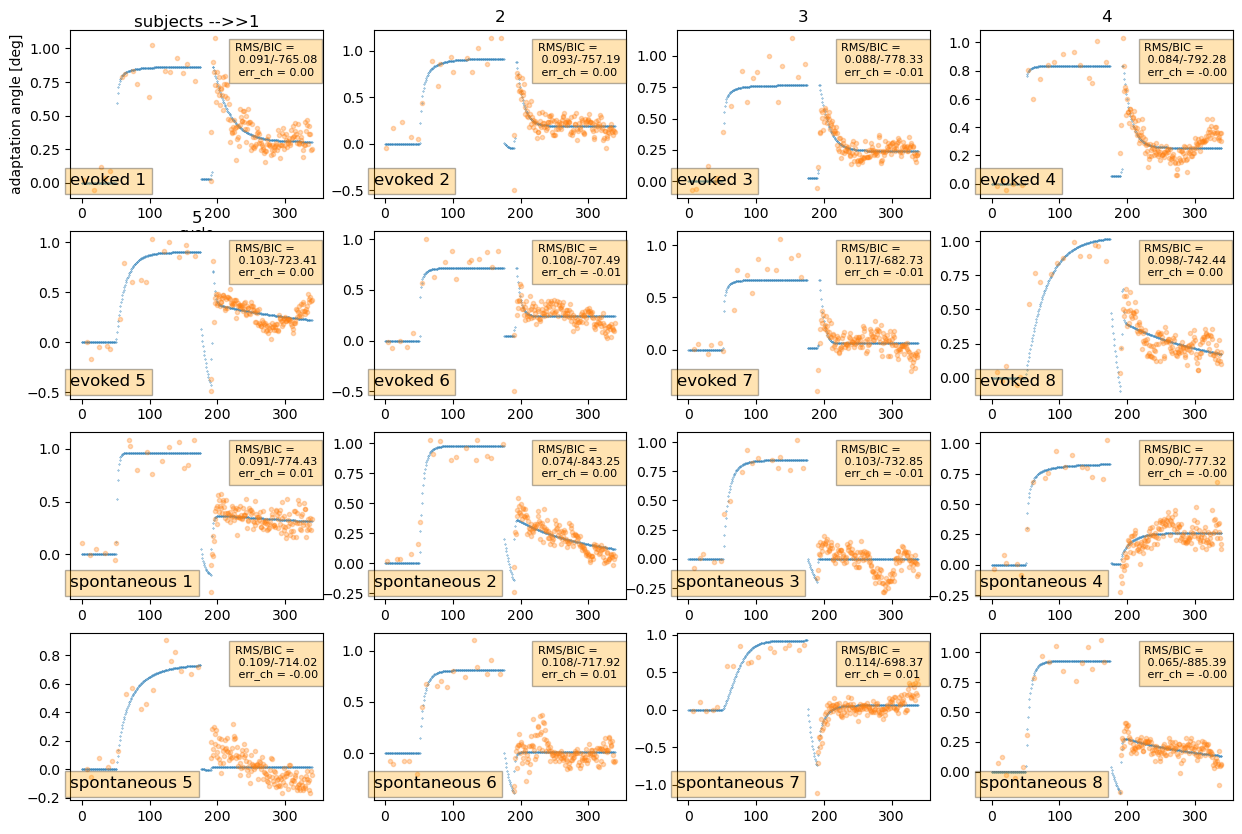

In [43]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    bic_value = bic( ydata_experiment,ydata_model, 5)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],'.',linewidth=0.5, markersize=0.6)
    plt.plot(data[k],'.', alpha=0.3)

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    plt.text(0.65, 0.82, f'RMS/BIC =\n {rms:.3f}/{bic_value:.2f}\n err_ch = {np.mean(ydata_experiment[-146:]-ydata_model[-146:]):.2f}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8,
                 bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [47]:
def bic_from_rmse(rmse, n_params, n_samples):
    """
    Calculate Bayesian Information Criterion (BIC) from RMSE.
    
    Parameters:
    rmse (float): Root Mean Square Error.
    n_params (int): Number of parameters in the model.
    n_samples (int): Number of samples in the dataset.
    
    Returns:
    float: BIC value.
    """
    return n_samples * np.log(rmse**2) + n_params * np.log(n_samples)

In [52]:
subj_rmse_bic = {}
for k in opt_params_manu:
    # print(f'Optimized parameters for {k}: {opt_params_manu[k].x}, rmse: {np.sqrt(opt_params_manu[k].fun)}')
    print(f'BIC: {bic_from_rmse(np.sqrt(opt_params_manu[k].fun), 5, np.sum(~np.isnan(data[k])))}')
    subj_rmse_bic[k] = {'rmse:': np.sqrt(opt_params_manu[k].fun),
                        'BIC': bic_from_rmse(np.sqrt(opt_params_manu[k].fun), 5, np.sum(~np.isnan(data[k])))}

BIC: -765.0831205899169
BIC: -757.1896463056862
BIC: -778.3259687015739
BIC: -792.2786965227557
BIC: -723.4068330265551
BIC: -707.4889506433581
BIC: -682.7317905794637
BIC: -742.441407062518
BIC: -774.4280290543215
BIC: -843.250285438961
BIC: -732.8451720423324
BIC: -777.3174093893642
BIC: -714.0248622577368
BIC: -717.9232559121091
BIC: -698.3692058452813
BIC: -885.3851588701845


In [ ]:
import numpy as np

def bic(measured_data, modeled_data, k_params,
        mode='white_gaussian',
        autoregressive_coeffs=None,
        autoregressive_sigma=None):
    """
    Compute the Bayesian Information Criterion (BIC) for a model fit,
    assuming normally distributed residuals.

    Parameters
    ----------
    measured_data : array-like
        The observed data (y_exp). NaNs here are handled per mode.
    modeled_data : array-like
        The model predictions (y_mod). Must not contain NaNs.
    k_params : int
        The number of free parameters in the model (p).
    mode : str
        'white_gaussian' (default) or 'autoregressive_gaussian'.
    autoregressive_coeffs : array-like, optional
        AR coefficients [a1, a2, …, ap] for the noise. Required if mode='autoregressive_gaussian'.
    autoregressive_sigma : float, optional
        Known noise standard deviation (σ). If None, estimated from data.

    Returns
    -------
    float
        The BIC value.
    """
    # 0) validate model output
    y_mod = np.asarray(modeled_data)
    if np.isnan(y_mod).any():
        raise ValueError("modeled_data contains NaN values; cannot proceed.")

    # 1) white‐noise Gaussian branch
    if mode == 'white_gaussian':
        y_exp = np.asarray(measured_data)
        mask = ~np.isnan(y_exp)
        y_exp_clean = y_exp[mask]
        y_mod_clean = y_mod[mask]

        n = y_exp_clean.size
        if n == 0:
            raise ValueError("No valid data points: all measured_data are NaN.")

        rss = np.sum((y_mod_clean - y_exp_clean) ** 2)
        return n * np.log(rss / n) + k_params * np.log(n)

    # 2) autoregressive‐noise Gaussian branch
    elif mode == 'autoregressive_gaussian':
        if autoregressive_coeffs is None:
            raise ValueError("autoregressive_coeffs must be provided for AR mode.")

        a = np.asarray(autoregressive_coeffs)
        p = a.size

        # 2a) handle missing data by zero‐imputation
        y_exp = np.asarray(measured_data)

        # 2b) raw residual series n_t = y_exp - y_mod
        n_series = y_exp - y_mod


        # 2c) pad the first p lags with zeros so we keep N innovations
        pad = np.zeros(p)
        N = n_series.size
        n_padded = np.concatenate([pad, n_series])
        valid_mask = ~np.isnan(n_padded)
        # 2d) compute innovations η_t = n_t - sum(a_i * n_{t-i})
        eta = np.empty(N)
        for t in range(p, p + N):
            #evolution
            evolution = np.dot(a, n_padded[t - p:t][::-1])
            if not valid_mask[t]: # if no observation supplied use evolution
                n_padded[t] = evolution
            #innovations
            eta[t - p] = n_padded[t] - evolution

        # 3) effective sample size and RSS
        valid_mask = valid_mask[p:]  # valid mask for innovations after padding
        eta_valid = eta[valid_mask]
        # print(n_padded)
        # print(eta_valid)
        n_eff = eta_valid.shape[0]
        # print(f"Effective sample size (n_eff): {n_eff}")
        rss_ar = np.sum(eta_valid ** 2)

        # 4) noise variance 
        if autoregressive_sigma is not None:
            sigma2 = autoregressive_sigma ** 2
            raise NotImplementedError("BIC for AR with known sigma is not implemented yet.")
        else:
            sigma2 = rss_ar / n_eff

        # 5) BIC formula
        bic_value = n_eff * np.log(rss_ar / n_eff) + k_params * np.log(n_eff)
        return bic_value

    else:
        raise ValueError(f"Unknown mode '{mode}'.")


In [111]:
for k in opt_params_manu:
    print(f'BIC: {bic(data[k], outs[k], 5, mode="white_gaussian")}')
    print(f'BICar: {bic(data[k], outs[k], 5, mode="autoregressive_gaussian", autoregressive_coeffs=[1e-3])}')
    # subj_rmse_bic[k]['BIC'] = bic(data[k], outs[k], 5, mode='white_gaussian')

BIC: -765.0831205899169
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.27748384e-02  2.27748384e-05  2.27748384e-08
  2.27748384e-11  2.27748384e-14  2.27748384e-17  2.27748384e-20
  2.27748384e-23  2.27748384e-26  2.27748384e-29  2.27748384e-32
  2.27748384e-35  2.27748384e-38  2.27748384e-41 -5.34387972e-02
 -5.34387972e-05 -5.34387972e-08 -5.34387972e-11 -5.34387972e-14
 -5.34387972e-17 -5.34387972e-20 -5.34387972e-23 -5.34387972e-26
 -5.34387972e-29 -5.34387972e-32  1.21245092e-01  1.21245092e-04
  1.21245092e-07  1.21245092e-10  1.21245092e-13  1.21245092e-16
  3.53099617e-02  3.53099617e-05  3.53099617e-08  3.53099617e-11
  3.53099617e-14  3.53099617e-17  3.53099617e-20  9.14289677e-02
  9.14289677e-05  9.14289677e-08  9.14289677e-11  9.14289677e-14
  9.14289677e-17  9.14289677e-20  9.14289677e-23  9.14289677e-26
  9.14289677e-29  9.14289677e-32  9.14289677e-35  9.14289677e-38
  9.14289677e-41  9.14289677e-44  9.14289677e-47  9.14289677e-50
 

In [ ]:
import pickle
# with open(f'{ROOT_PATH}/experimental/subj_rmse_bic_clNN5p.pkl', 'wb') as f:
#     pickle.dump(subj_rmse_bic, f)

Text(0.5, 1.0, 'subjects -->>1')

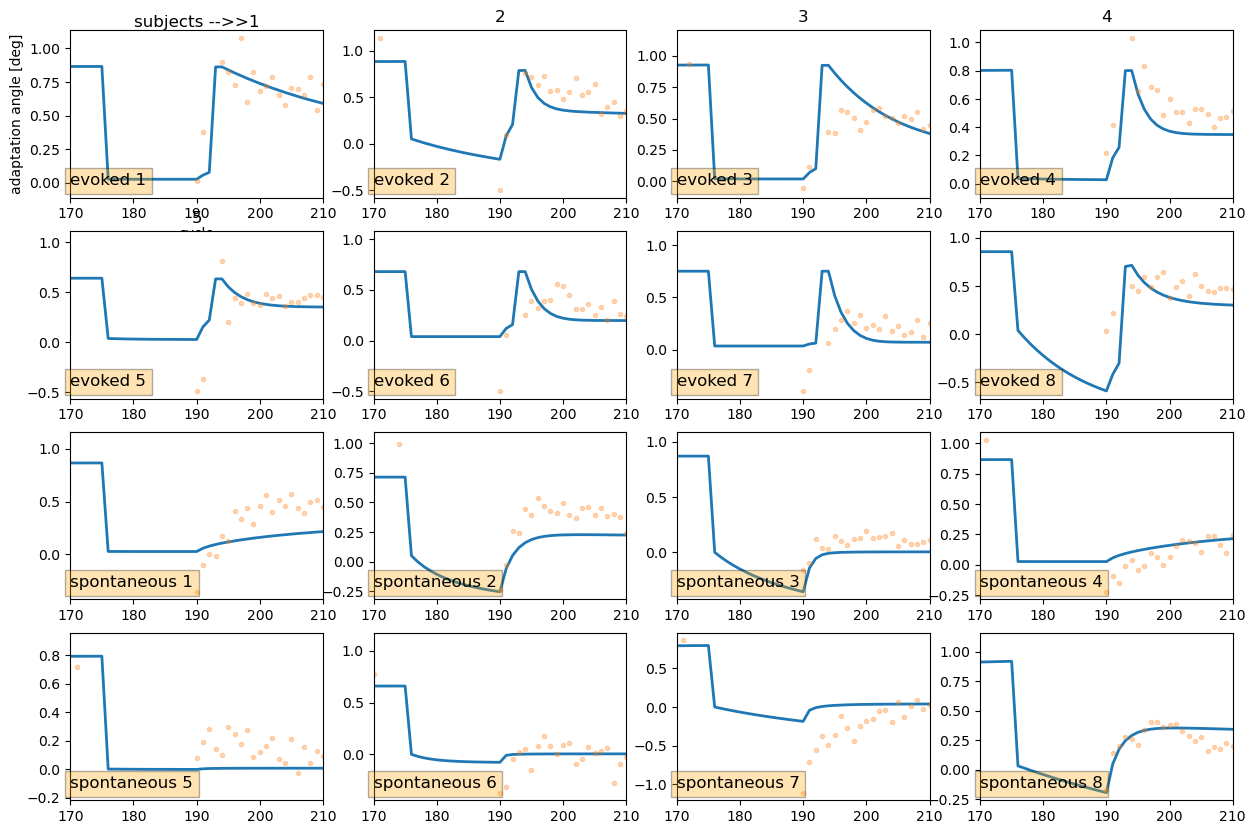

In [30]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    bic_value = bic( ydata_experiment,ydata_model, 4)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    plt.xlim([170,210])

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    # plt.text(0.6, 0.2, f'RMS/BIC =\n {rms:.2f}/{bic_value:.2f}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [31]:
raise ValueError('stop here')

ValueError: stop here

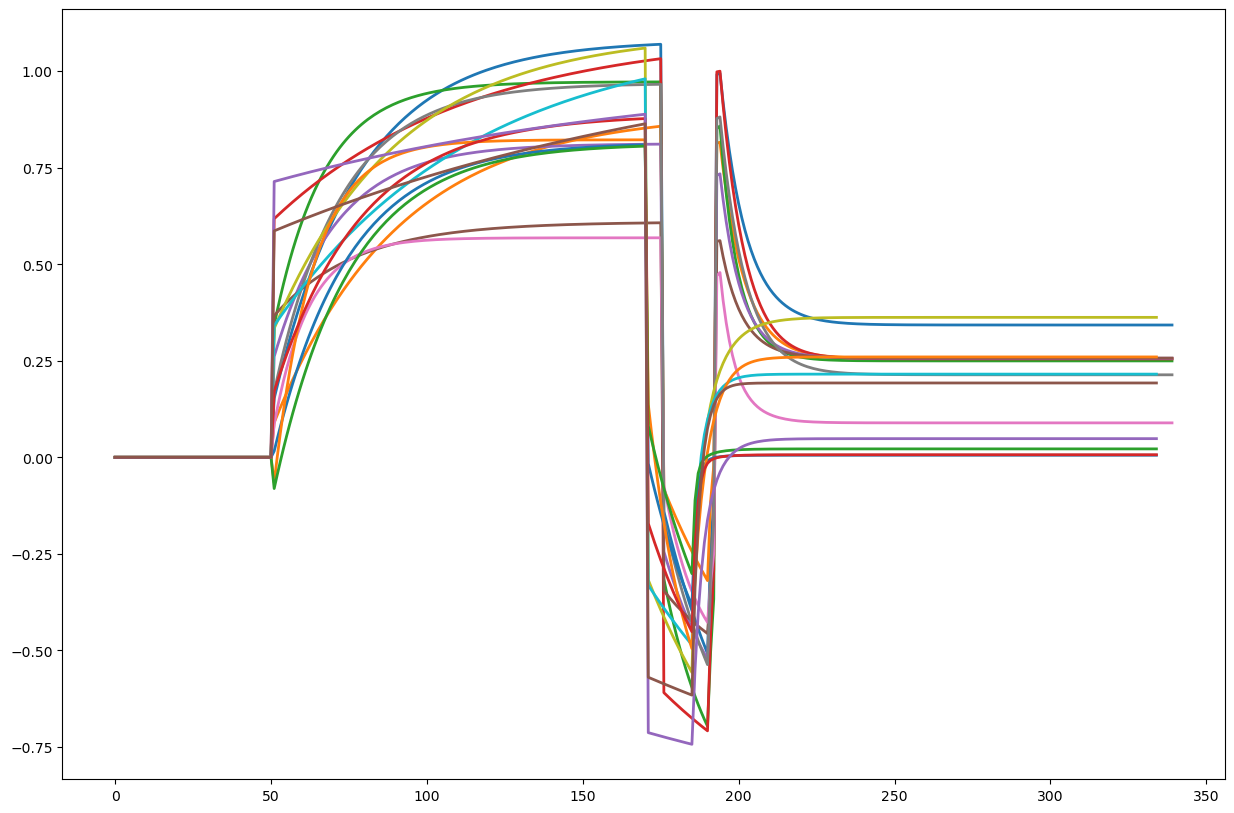

In [ ]:
plt.figure(figsize=(15,10))
for k in opt_data:
    # plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    # plt.plot(data[k],'.', alpha=0.3)
    # if k<5: plt.title(f'{k+1}')
    # plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# # plt.ylabel('adaptation angle [deg]')
# # plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [45]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

antero   = {aa: [ wrapped_runner(aa_item,opt_params_manu[k]['x']) for k in opt_params_manu] for aa,aa_item in ref_antero_playlist.items()}

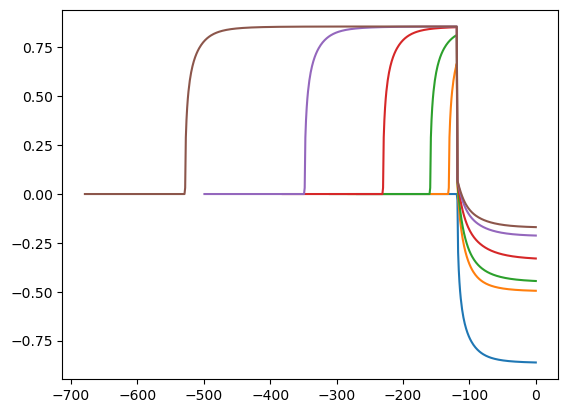

In [46]:
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

In [53]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

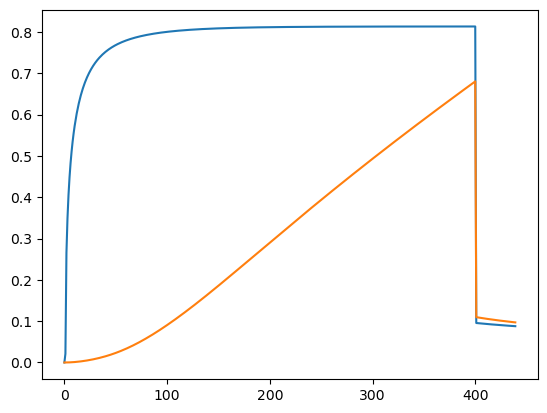

In [54]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [55]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
# her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

In [56]:
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

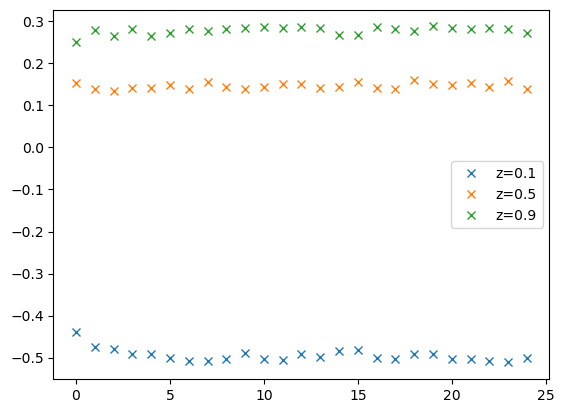

In [62]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')
plt.legend()

# for frog_en in frog_ens:
#     plt.plot(np.mean(frogs[frog_en],axis=0))

In [58]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}

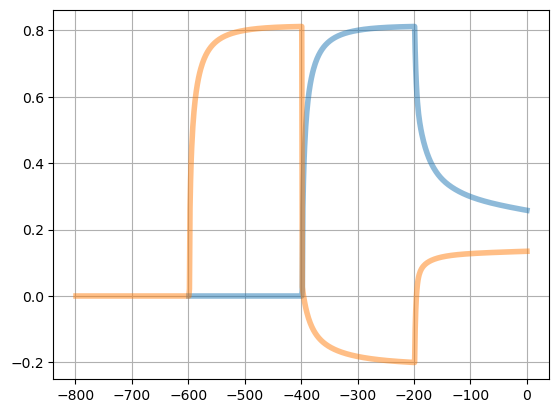

In [59]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

In [60]:
from dsp_utils import parse_samples

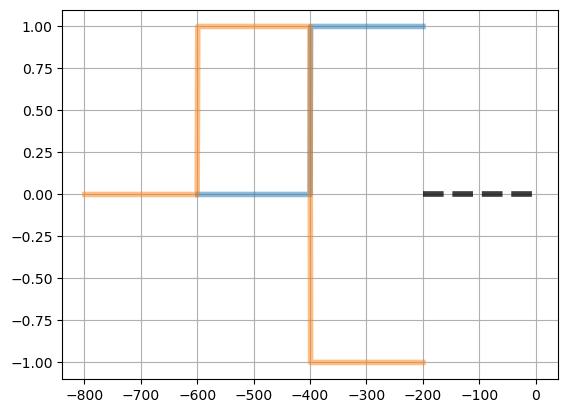

In [61]:
for aa,aa_item in playlist.items():
    y = parse_samples(playlist[aa])
    x = np.arange(len(y))
    x = x - x[-1]    
    plt.plot(x,y, linewidth=4, alpha=0.5)
    #get a vector where nans replaced by 0 and every non-nan replaced by nan
    y_nan = np.nan*np.ones(len(y))
    y_nan[np.isnan(y)] = 0
    plt.plot(x,y_nan, 'k--',linewidth=4, alpha=0.5)
plt.grid()